###Problem statement

Develop an interactive software application tailored for kindergarten children to aid in learning colors, shapes, and characters using Pokémon images and captions. By fine-tuning a state-of-the-art multimodal model with the Pokémon BLIP captions dataset, the software will generate interactive and enriching captions for each Pokémon image to enhance visual and cognitive learning. This application aims to provide an enriching educational experience by incorporating playful and familiar Pokémon characters, making the learning process fun and interactive for young learners.

In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
#check the CUDA version
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
#install the necessary libraries
!pip install transformers datasets evaluate -q
!pip install jiwer -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarr

In [ ]:
#load the pokemon dataset from the datasets library
from datasets import load_dataset
ds = load_dataset("reach-vb/pokemon-blip-captions")
ds

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 833
    })
})

In [ ]:
#split the dataset
ds = ds["train"].train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]

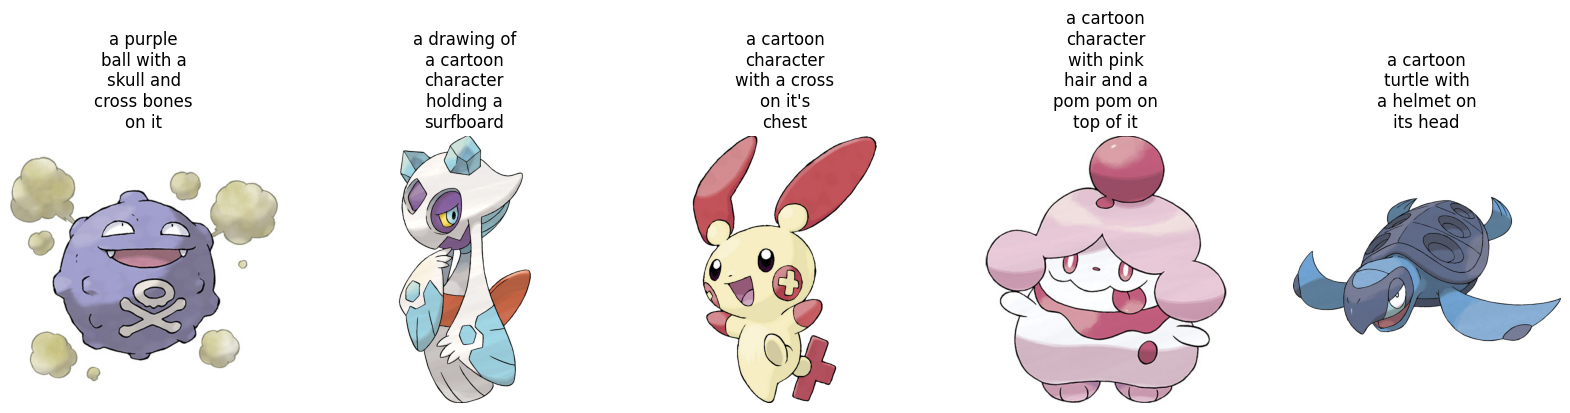

In [ ]:
#visualize a couple of samples from the training set
from textwrap import wrap  # Importing the wrap function to handle text wrapping
import matplotlib.pyplot as plt  # Importing matplotlib for plotting images
import numpy as np

def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        # Wrapping the caption text to fit in the plot
        caption = "\n".join(wrap(caption, 12))
        # Setting the title of the subplot to the caption
        plt.title(caption)

        plt.imshow(images[i])
        plt.axis("off")

# Extracting sample images from the dataset for visualization
sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
# Extracting corresponding captions for the images
sample_captions = [train_ds[i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)


Since the dataset includes both image and text modalities, the preprocessing pipeline must handle both types of data. To achieve this, load the processor class associated with the model you intend to fine-tune.

###GIT (GenerativeImage2Text), base-sized
GIT (short for GenerativeImage2Text) model, base-sized version. GIT is a Transformer decoder that is conditioned on both CLIP image tokens and text tokens. The model is trained using "teacher forcing" on numerous (image, text) pairs. Its primary objective is to predict the next text token based on the provided image tokens and preceding text tokens.

The model utilizes a bidirectional attention mask for the image patch tokens, granting full access to the image data. However, when predicting the next text token, it employs a causal attention mask for the text tokens, allowing it to access only the previous text tokens.

In [ ]:
from transformers import AutoProcessor

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

The processor will internally handle the image preprocessing, which includes resizing and pixel scaling, and will tokenize the caption.

In [ ]:
#transform the dataset for finetuning
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

In [ ]:
#Load the “microsoft/git-base” into a AutoModelForCausalLM object.
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(checkpoint)

Image captioning models are typically evaluated using metrics like the ROUGE score or Word Error Rate (WER). In this context, we use Hugging Face libraries to calculate WER.

In [ ]:
from evaluate import load
import torch
# Load the Word Error Rate (WER) evaluation metric
wer = load("wer")

#compute metrics during evaluation
def compute_metrics(eval_pred):
   # Unpack the evaluation predictions into logits and labels
    logits, labels = eval_pred
    # Get the index of the maximum logit value for each prediction
    predicted = logits.argmax(-1)
    #decode the labels and predicted tokens
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)

    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

Train the model

In [ ]:
from transformers import Trainer, TrainingArguments
from transformers import default_data_collator
import os


output_directory = os.path.join("../working/cache", "captioning_outputs")
# define the training arguments using TrainingArguments.
training_args = TrainingArguments(
    output_dir=output_directory,
    learning_rate=5e-5,
    num_train_epochs=50,
    fp16=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    remove_unused_columns=False,
    label_names=["labels"],
    report_to="none")
#pass arguments along with the datasets and the model to Huggingface Trainer.
trainer = Trainer(
    model=model,
    args=training_args,
     train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,

)


In [ ]:
# clear GPu cache
#torch.cuda.empty_cache()
#call train() on the Trainer object to start training
trainer.train()

Step,Training Loss
500,0.948400
1000,0.000600


TrainOutput(global_step=1150, training_loss=0.41268706648893977, metrics={'train_runtime': 2114.3248, 'train_samples_per_second': 17.713, 'train_steps_per_second': 0.544, 'total_flos': 1.7143374772076544e+16, 'train_loss': 0.41268706648893977, 'epoch': 48.93617021276596})

Test the model with some images

In [ ]:
from PIL import Image
import requests
def display_image(url):
  image = Image.open(requests.get(url, stream=True).raw)
  # Display the image
  display(image)
  return image
def generate_captions(image):
  #Prepare image for the model.
  device = "cuda" if torch.cuda.is_available() else "cpu"
  inputs = processor(images=image, return_tensors="pt").to(device)
  pixel_values = inputs.pixel_values
  #generate captions
  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  return generated_caption


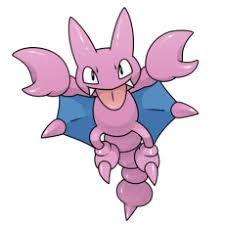

a pink cartoon character with a blue tail


In [ ]:
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT2WJe1rqww9JKg9YPeMZVAQRQAYtjs0EMMzDaS21ljTTT_nPmA"
image=display_image(url)
answer = generate_captions(image)
print(answer)

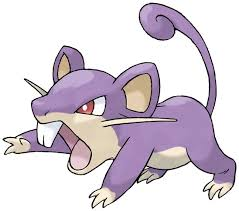

a drawing of a purple cat with its mouth open


In [ ]:
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQf2NbpcW4a1__ejOQ12bdffBy3nGgPiGps3Q&usqp=CAU"
image=display_image(url)
answer = generate_captions(image)
print(answer)